In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import pymc3 as pm

In [2]:
x = np.linspace(0, 10, 50)

def exp_kermal(x, y, l):
    out = [np.exp(-((m-n)**2 / l**2)) for i,m in enumerate(x) for j,n in enumerate(y)]
    return np.reshape(out, (len(x), len(y)))

def brown_kernal(x, y, l):
    out = [np.exp(-(np.abs(m-n) / l**2)) for i,m in enumerate(x) for j,n in enumerate(y)]
    return np.reshape(out, (len(x), len(y)))


# Draw Samples from the Prior

In [3]:
sigma = exp_kermal(x, x, 2)
mu = np.zeros(len(x))
sample = np.random.multivariate_normal(mu, sigma, size=5)
sample.shape

(5, 50)

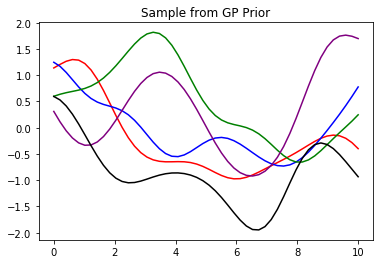

In [4]:
colors = ["red", "blue", "green", "purple", "black"]
for k, v in enumerate(colors):
    plt.plot(x, sample[k,:], color=v)
    plt.title("Sample from GP Prior")

# Fitting the GP to data

Given that $y_i \sim N(\mu, \sigma^2),\;i=1,...,n$, the GP Priors are convienent because they are conditinally conjugate so that the conditional posterior is also a Gaussian process with new $\mu$ and $\Sigma$. Given a GP Prior, $GP(0,k)$, the joint density for the observations and additional locations, $\hat{x}$ is:

$$\hat{\mu} \sim N(\mathbb{E}\left[\hat{\mu}\right], cov\left[\hat{\mu}\right])$$
where:

\begin{align*}
\mathbb{E}\left[\hat{\mu}\right] & = k(x, \hat{x})k(x,x)^{-1} y\\
cov\left[\hat{\mu}\right] & = k(\hat{x}, k(\hat{x}) - k(\hat{x}, x)k(x,x)^{-1}k(x,\hat{x})
\end{align*}



# Example

Given a set of points $(2,0), (4,1), (6, -1), (8,4)$ we can condition our priors using the above equations, and then take 50 samples from the multivariate normal posterior. I've defined the function "GP_cond" to accept any kernal you wish to include. Usually the choice of kernal is determined by some prior knowledge about the problem.


In [5]:
y = np.array([[2, 4, 6, 8], [0, 1, -1, 4]]).transpose()
sig = 0

def GP_cond(x, y, xhat, kernal, sig=0, l=1):
    """
    Calculates the conditional Gaussian Process. Expects x, y as column arrays
    """
    k_xx = kernal(x, x, l) + np.diag(np.zeros(len(y)) + sig)
    k_xxh = kernal(x, xhat, l)
    k_xhxh = kernal(xhat, xhat, l)
    k_xhx = kernal(xhat, x, l)

    mu = np.dot(np.dot(k_xhx, np.linalg.inv(k_xx)), y)
    cov = k_xhxh - np.dot(np.dot(k_xhx, np.linalg.inv(k_xx)),  k_xxh)

    return mu, cov

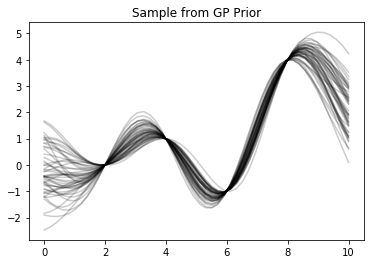

In [6]:
num_draws = 50
mu, sigma = GP_cond(y[:,0], y[:,1], x, exp_kermal, sig=0, l=2)
sample = np.random.multivariate_normal(mu, sigma, size=num_draws)

for k in range(num_draws):
    plt.plot(x, sample[k,:], color="black", alpha=.2)
    plt.title("Sample from GP Prior")

# Birthdays Example

Text(0.5, 1.0, 'Number of Births per Day')

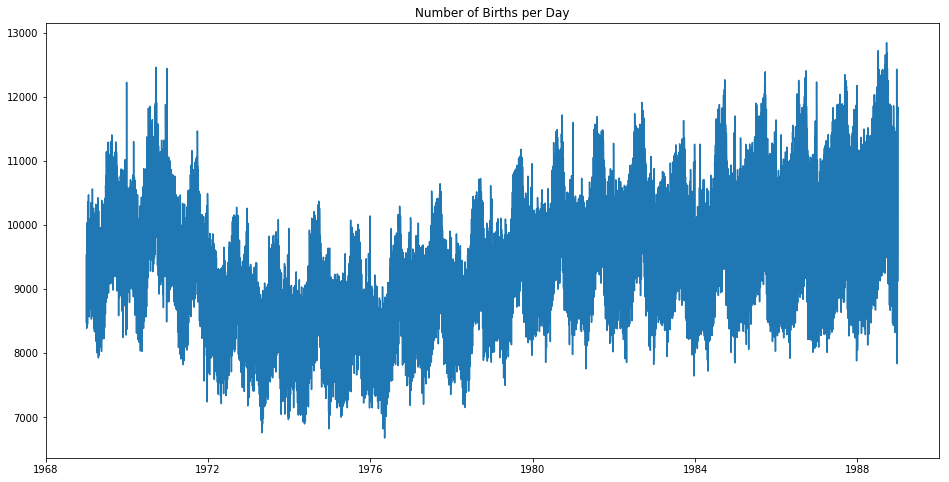

In [27]:
birthdays = pd.read_csv("~/Documents/birthdays.txt")
birthdays["date"] = pd.to_datetime(birthdays[["year", "month", "day"]])

plt.figure(figsize=(16,8))
plt.plot(birthdays.date, birthdays.births)
plt.title("Number of Births per Day")

We can focus in on a single year. Here we simply filter the data down to 1976 and notice the weekly trend, and potential seasonal pattern. It's difficult to detrmin whether or not holiday effects are present given this representation. 

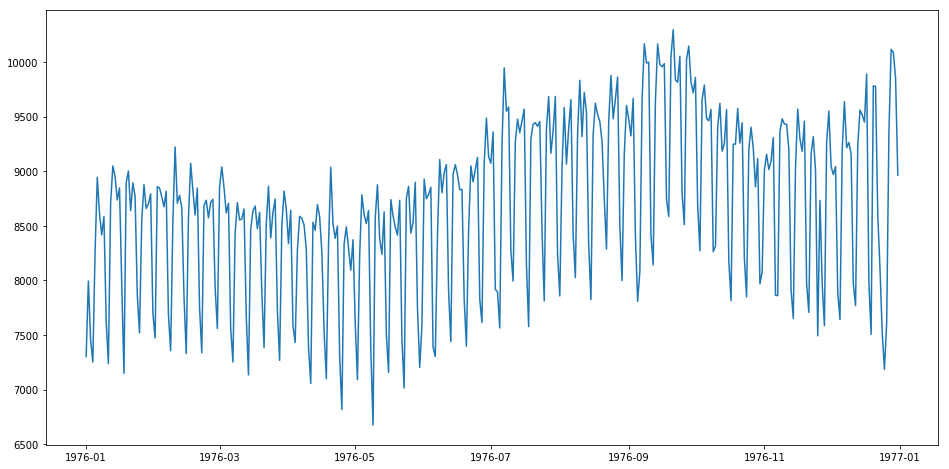

In [26]:
bd_1976 = birthdays.query("year == 1976")
plt.figure(figsize=(16,8))
plt.plot(bd_1976.date, bd_1976.births)